# 集成学习
集成学习（ensemble learning）会考虑多个评估器的建模结果，汇总之后得到一个综合的结果，以此来获取比单个模型更好的回归或分类表现。

多个模型集成成为的模型叫做集成评估器（ensemble estimator），组成集成评估器的每个模型都叫做基评估器（base estimator）。通常来说，有三类集成算法：装袋法（Bagging），提升法（Boosting）和stacking。

装袋法的核心思想是构建多个相互独立的评估器，然后对其预测进行平均或多数表决原则来决定集成评估器的结果。装袋法的代表模型就是随机森林。

提升法中，基评估器是相关的，是按顺序一一构建的。其核心思想是结合弱评估器的力量一次次对难以评估的样本进行预测，从而构成一个强评估器。提升法的代表模型有Adaboost和梯度提升树。

# RandomForestClassifier
class sklearn.ensemble.RandomForestClassifier (n_estimators=’10’, criterion=’gini’, max_depth=None,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’,
max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False,
n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)

n_estimators是森林中树木的数量，即基评估器的数量。这个参数对随机森林模型的精确性影响是单调的，n_estimators越
大，模型的效果往往越好。

random_state固定时，随机森林中生成是一组固定的树，但每棵树依然是不一致的

bootstrap参数默认True，代表采用这种有放回的随机抽样技术。通常，这个参数不会被我们设置为False。

oob_score_来查看我们的在袋外数据上测试的结果（也就是创建森林的时候没有用到的数据）如果希望用袋外数据来测试，则需要在实例化时就将oob_score这个参数调整为True

In [1]:
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine

In [2]:
wine = load_wine()

In [3]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(wine.data,
                                                wine.target,
                                                test_size=0.3)
clf = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)
clf = clf.fit(Xtrain, Ytrain)
rfc = rfc.fit(Xtrain, Ytrain)
score_c = clf.score(Xtest, Ytest)
score_r = rfc.score(Xtest, Ytest)
print("Single Tree:{}".format(score_c), "Random Forest:{}".format(score_r)) # 这里大括号就是后面format括弧里的内容


Single Tree:0.9444444444444444 Random Forest:0.9814814814814815


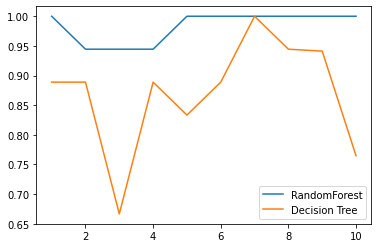

In [7]:
#交叉验证：是数据集划分为n分，依次取每一份做测试集，每n-1份做训练集，多次训练模型以观测模型稳定性的方法
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

rfc = RandomForestClassifier(n_estimators=25) # 实例化，25棵树的森林
rfc_s = cross_val_score(rfc,wine.data,wine.target,cv=10) # 交叉验证（模型对象，特征，标签，划分数量）

clf = DecisionTreeClassifier()
clf_s = cross_val_score(clf,wine.data,wine.target,cv=10)

plt.plot(range(1,11),rfc_s,label = "RandomForest")
plt.plot(range(1,11),clf_s,label = "Decision Tree")
plt.legend() # 显示线条标题
# plt.show()

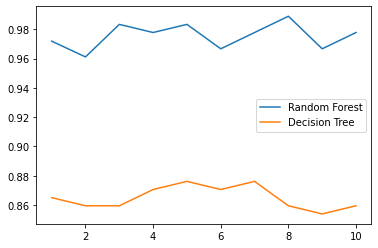

In [8]:
rfc_l = [] # 这个list用来放每次的结果
clf_l = []
for i in range(10):
    rfc = RandomForestClassifier(n_estimators=25)
    rfc_s = cross_val_score(rfc,wine.data,wine.target,cv=10).mean() # mean()取十次平均值
    rfc_l.append(rfc_s)
    clf = DecisionTreeClassifier()
    clf_s = cross_val_score(clf,wine.data,wine.target,cv=10).mean()
    clf_l.append(clf_s)
    
plt.plot(range(1,11),rfc_l,label = "Random Forest")
plt.plot(range(1,11),clf_l,label = "Decision Tree")
plt.legend()
plt.show()
#是否有注意到，单个决策树的波动轨迹和随机森林一致？
#再次验证了我们之前提到的，单个决策树的准确率越高，随机森林的准确率也会越高

0.9888888888888889 17


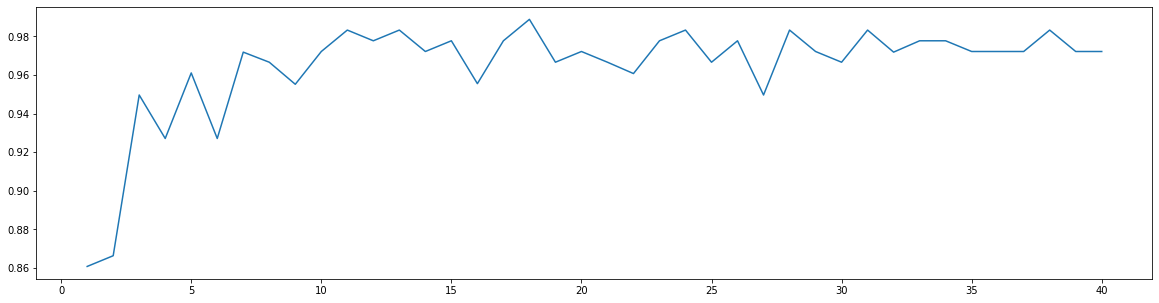

In [11]:
# n_estimators越大交叉验证成绩越好
superpa = []
for i in range(40):
    rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1)
    rfc_s = cross_val_score(rfc,wine.data,wine.target,cv=10).mean()
    superpa.append(rfc_s)
print(max(superpa),superpa.index(max(superpa)))
plt.figure(figsize=[20,5])
plt.plot(range(1,41),superpa)

In [10]:
#用袋外数据来测试我们的模型
#无需划分训练集和测试集
rfc = RandomForestClassifier(n_estimators=25,oob_score=True)
rfc = rfc.fit(wine.data,wine.target)
#重要属性oob_score_
rfc.oob_score_

0.9662921348314607

# RF乳腺癌数据上的调参
偏差衡量模型是否预测得准确，偏差越小，模型越“准”；而方差衡量模型每次预测的结果是否接近，即是说方差越小，模型越“稳”

复杂度高，方差高，总泛化误差高。复杂度低，偏差高，总泛化误差高。

以随机森林为代表的装袋法的训练过程旨在降低方差，即降低模型复杂度，所以随机森林参数的默认设定都是假设模型本身在泛化误差最低点的右边。

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
data = load_breast_cancer()
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [14]:
data.data.shape

(569, 30)

In [15]:
data.target
#可以看到，乳腺癌数据集有569条记录，30个特征，单看维度虽然不算太高，但是样本量非常少。过拟合的情况可能存在

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [24]:
rfc = RandomForestClassifier(n_estimators=100,random_state=20)
score_pre = cross_val_score(rfc,data.data,data.target,cv=10).mean()
score_pre

0.9648809523809524

0.9631265664160402 71


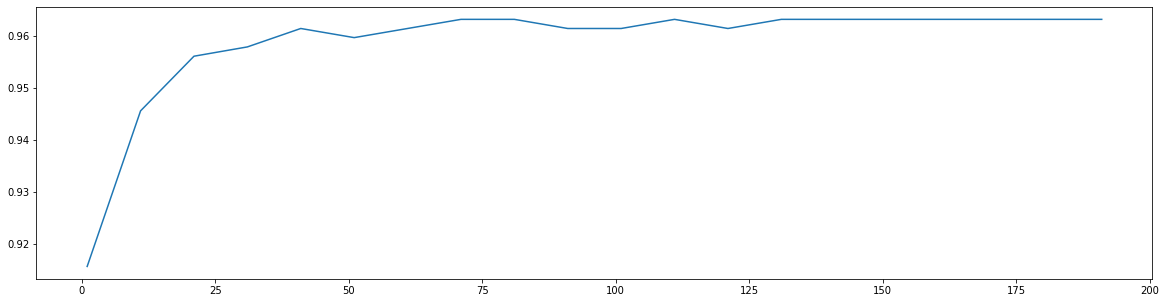

In [17]:
# 第一次的学习曲线，可以先用来帮助我们划定范围
scorel = []
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()
#list.index([object])
#返回这个object在列表list中的索引

0.9613721804511279 41


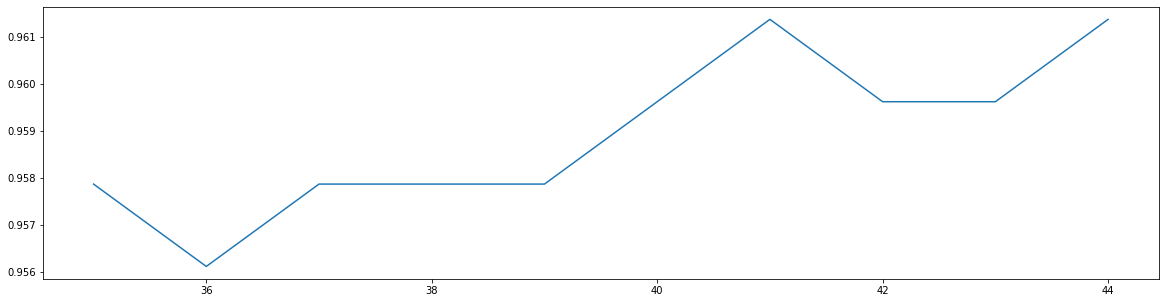

In [19]:
# 在确定好的范围内，进一步细化学习曲线

scorel = []
for i in range(35,45):
    rfc = RandomForestClassifier(n_estimators=i,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,data.data,data.target,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(35,45)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(35,45),scorel)
plt.show()

In [28]:
# 网格搜索最佳参数，这里举例两个
# 实际应用时不一定一起搜索，可能会很慢，可以一个一个调
param_grid = {
    'max_depth': np.arange(1, 20, 1),
    'criterion': ['gini', 'entropy']
}
# 一般根据数据的大小来进行一个试探，乳腺癌数据很小，所以可以采用1~10，或者1~20这样的试探
# 但对于像digit recognition那样的大型数据来说，我们应该尝试30~50层深度（或许还不足够
#   更应该画出学习曲线，来观察深度对模型的影响
rfc = RandomForestClassifier(n_estimators=41, random_state=90)
GS = GridSearchCV(rfc, param_grid, cv=10)
GS.fit(data.data, data.target)
GS.best_params_

{'criterion': 'entropy', 'max_depth': 7}

In [29]:
GS.best_score_

0.9701754385964912